In [1]:
import sys
sys.path.append("..")
import argparse
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn import metrics

import torch
import torch.nn as nn
import copy
import model
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import st_loss
import seaborn as sns
import h5py
import scipy as sp
import scanpy.api as sc
from collections import Counter
import utils
import loop
import pickle
import os
import glob2
plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/opt/conda/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
category = "imbalanced_data"
path="../"
args = {
    "dims": [499, 256, 64, 32],
    "highly_genes": 500,
    'alpha': 0.001,
    'gamma': 0.001,
    'learning_rate': 0.0001,
    'update_epoch': 10,
    't_alpha': 1,
    'error': 0.001
}
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
args = objectview(args) 

files = glob2.glob(f'{path}R/simulated_data/{category}/*.h5')
files = [f[len(f"{path}R/simulated_data/{category}/"):-3] for f in files]
files

['data_1c8',
 'data_-1c4',
 'data_-1c8',
 'data_0c4',
 'data_0c8',
 'data_0c16',
 'data_1.5c4',
 'data_1c32',
 'data_1c4',
 'data_1.5c8',
 'data_1.5c16',
 'data_0c32',
 'data_1.5c32',
 'data_-1c32',
 'data_-1c16',
 'data_1c16']

In [ ]:
dr = pd.DataFrame(columns = ["dataset", "dropout", "perc0",  "nd", "exp", "ari"])
for run in range(1):
    df = pd.DataFrame()

    print(df.shape)
    for dataset in files:
        print(f">>>>> Data {dataset}")

        data_mat = h5py.File(f"{path}R/simulated_data/{category}/{dataset}.h5", "r")
        dp = data_mat['dropout'][0]
        X = np.array(data_mat['X'])
        Y = np.array(data_mat['Y'])
        perc_0 = np.where(X ==0)[0].shape[0]/(X.shape[0]*X.shape[1])
        print(f"Perc 0 {perc_0}")
        X = np.ceil(X).astype(np.int)
        count_X = X
        print(X.shape, count_X.shape)
        orig_X = X.copy()
        adata = sc.AnnData(X)
        adata.obs['Group'] = Y
        adata = utils.normalize(adata,
                          copy=True,
                          highly_genes=args.highly_genes,
                          size_factors=True,
                          normalize_input=True,
                          logtrans_input=True)
        X = adata.X.astype(np.float32)
        Y = np.array(adata.obs["Group"])
        print(X.shape, count_X.shape)

        high_variable = np.array(adata.var.highly_variable.index, dtype=np.int)
        count_X = count_X[:, high_variable]
        size_factor = np.array(adata.obs.size_factors).reshape(-1,
                                                               1).astype(np.float32)
        cluster_number = int(max(Y) - min(Y) + 1)
        zeros = np.min(X, axis = 0)
        X.shape, count_X.shape

        pxt = PCA(2).fit_transform(X)
        dresults = {
            "dataset": dataset,
            "nclust": cluster_number,
            "original": utils.evaluate(X, Y, cluster_number)[1],
            "pca": utils.evaluate(pxt, Y, cluster_number)[1],
            "perc_0": perc_0
        }
        
        # 3 models
        st_results = []

        f = []
        for nd in [100, 200, 300, 400]:
            print(f"nd = {nd}")
            nm = nd
            r1 = loop.self_train_clustering(X,
                   Y,
                   cluster_number,
                   args,
                   augm_zeros=None,
                   nb_zeros = nd,
                   random=False,
                   perc=0.1,
                   augm_value=0,
                   epochs = 500)
            f.append(r1['features'])
            st_results.append(r1)

            dresults[f"self_initial_{nm}"] = r1["aris_kmeans_representation"][-1]
            dresults[f"self_{nm}"] = r1["aris_kmeans_representation"][-1]
            dr.loc[dr.shape[0]] = [dataset, dp, perc_0, nd, "method1",r1["aris_kmeans_representation"][-1]]
            dr.loc[dr.shape[0]] = [dataset, dp, perc_0, nd, "method2",r1["aris_kmeans_representation"][-1]]
            
            print("ARI ", r1["aris1"][-1])
        ft = np.hstack(f)
        kmeans = KMeans(n_clusters=cluster_number, init="k-means++", random_state=0)
        pred = kmeans.fit_predict(ft)

        dresults[f"combined_features"] = adjusted_rand_score(Y, pred)
        print("combined: ", dresults[f"combined_features"])
        dr.loc[dr.shape[0]] = [dataset, dp, perc_0, -1, "method3",dresults[f"combined_features"]]
        

        df = df.append(dresults, ignore_index=True)
        print(dresults)

        all_res = dresults.copy()
        all_res["st"] = st_results
        if os.path.isdir(f"{path}output/{category}/") == False:
            os.makedirs(f"{path}output/{category}/",exist_ok=True)
        with open(f"{path}output/{category}/results_{dataset}_{run}_mixed.pickle", 'wb') as handle:
            pickle.dump(dresults, handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(f"{path}output/{category}/detailed_results_{dataset}_{run}_mixed.pickle", 'wb') as handle:
            pickle.dump(all_res, handle, protocol=pickle.HIGHEST_PROTOCOL)
        df.to_pickle(f"{path}output/pickle_results/{category}/real_data_{run}_mixed.pkl")
        dr.to_pickle(f"{path}output/pickle_results/{category}/real_data_augmentation.pkl")

In [3]:
dr = pd.read_pickle(f"{path}output/pickle_results/{category}/real_data_augmentation.pkl")

In [4]:
def get_label(x):
    if x == -1: 
        return "combined"
    if x == 100:
        return "80 %"
    if x == 200:
        return "60 %"
    if x == 300:
        return "40 %"
    if x == 400:
        return "20 %"

dr["label"] = dr["nd"].apply(get_label)

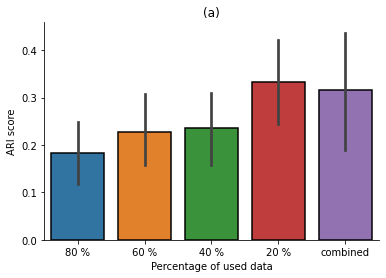

In [5]:
plt.title("(a)")
sns.barplot(
    x="label",
    y="ari",
    data=dr,
    edgecolor='black',
    linewidth=1.5,
)
plt.xlabel("Percentage of used data")
plt.ylabel("ARI score")
sns.despine()
plt.savefig(f"{path}diagrams/dropout.pdf", bbox_inches='tight')